In [ ]:
"""
This code is written by: Ben Moseley
https://github.com/benmoseley/FBPINNs/tree/pytorch/seismic-cpml

I have modified it according to my requirements
"""

In [4]:
import numpy as np
import time
from seismic_CPML_helper import get_dampening_profiles
import torch
import matplotlib.pyplot as plt

# todo: is this faster in parallel with np.roll?

In [5]:
def seismicCPML2D(NX,
                NY,
                NSTEPS,
                DELTAX,
                DELTAY,
                DELTAT,
                NPOINTS_PML,
                velocity,
                density,
                initial_pressures,
                f0=20.,
                dtype=np.float32,
                output_wavefields=True,
                gather_is=None):
    
    "Run seismicCPML2D"
    
    ## INPUT PARAMETERS
    velocity = velocity.astype(dtype)
    density = density.astype(dtype)
    
    if type(gather_is) != type(None): output_gather = True
    else: output_gather = False
    
    K_MAX_PML = 1.
    ALPHA_MAX_PML = 2.*np.pi*(f0/2.)# from Festa and Vilotte
    NPOWER = 2.# power to compute d0 profile
    Rcoef = 0.001
    
    STABILITY_THRESHOLD = 1e25
    ##
    
    
    # STABILITY CHECKS
    
    # basically: delta x > np.sqrt(3) * max(v) * delta t
    courant_number = np.max(velocity) * DELTAT * np.sqrt(1/(DELTAX**2) + 1/(DELTAY**2))
    if courant_number > 1.: raise Exception("ERROR: time step is too large, simulation will be unstable %.2f"%(courant_number))
    if NPOWER < 1: raise Exception("ERROR: NPOWER must be greater than 1")
    
    
    # GET DAMPENING PROFILES
    
    [[a_x, a_x_half, b_x, b_x_half, K_x, K_x_half],
     [a_y, a_y_half, b_y, b_y_half, K_y, K_y_half]] = get_dampening_profiles(velocity, NPOINTS_PML, Rcoef, K_MAX_PML, ALPHA_MAX_PML, NPOWER, DELTAT, DELTAS=(DELTAX, DELTAY), dtype=dtype, qc=False)
    

    # INITIALISE ARRAYS
    
    kappa = density*(velocity**2)
    
    pressure_present = initial_pressures[1].astype(dtype)
    pressure_past = initial_pressures[0].astype(dtype)
    
    memory_dpressure_dx = np.zeros((NX, NY), dtype=dtype)
    memory_dpressure_dy = np.zeros((NX, NY), dtype=dtype)
    
    memory_dpressurexx_dx = np.zeros((NX, NY), dtype=dtype)
    memory_dpressureyy_dy = np.zeros((NX, NY), dtype=dtype)
    
    if output_wavefields: wavefields = np.zeros((NSTEPS, NX, NY), dtype=dtype)
    if output_gather: gather = np.zeros((gather_is.shape[0], NSTEPS), dtype=dtype)
    
    # precompute density_half arrays
    density_half_x = np.pad(0.5 * (density[1:NX,:]+density[:NX-1,:]), [[0,1],[0,0]], mode="edge")
    density_half_y = np.pad(0.5 * (density[:,1:NY]+density[:,:NY-1]), [[0,0],[0,1]], mode="edge")
    
    
    # RUN SIMULATION
    
    start = time.time()
    for it in range(NSTEPS):
                
        # compute the first spatial derivatives divided by density
        
        value_dpressure_dx = np.pad((pressure_present[1:NX,:]-pressure_present[:NX-1,:]) / DELTAX, [[0,1],[0,0]], mode="constant", constant_values=0.)
        value_dpressure_dy = np.pad((pressure_present[:,1:NY]-pressure_present[:,:NY-1]) / DELTAY, [[0,0],[0,1]], mode="constant", constant_values=0.)
    
        memory_dpressure_dx = b_x_half * memory_dpressure_dx + a_x_half * value_dpressure_dx
        memory_dpressure_dy = b_y_half * memory_dpressure_dy + a_y_half * value_dpressure_dy
    
        value_dpressure_dx = value_dpressure_dx / K_x_half + memory_dpressure_dx
        value_dpressure_dy = value_dpressure_dy / K_y_half + memory_dpressure_dy
    
        pressure_xx = value_dpressure_dx / density_half_x
        pressure_yy = value_dpressure_dy / density_half_y
        
        # compute the second spatial derivatives
        
        value_dpressurexx_dx = np.pad((pressure_xx[1:NX,:]-pressure_xx[:NX-1,:]) / DELTAX, [[1,0],[0,0]], mode="constant", constant_values=0.)
        value_dpressureyy_dy = np.pad((pressure_yy[:,1:NY]-pressure_yy[:,:NY-1]) / DELTAY, [[0,0],[1,0]], mode="constant", constant_values=0.)
    
        memory_dpressurexx_dx = b_x * memory_dpressurexx_dx + a_x * value_dpressurexx_dx
        memory_dpressureyy_dy = b_y * memory_dpressureyy_dy + a_y * value_dpressureyy_dy
        
        value_dpressurexx_dx = value_dpressurexx_dx / K_x + memory_dpressurexx_dx
        value_dpressureyy_dy = value_dpressureyy_dy / K_y + memory_dpressureyy_dy
        
        dpressurexx_dx = value_dpressurexx_dx
        dpressureyy_dy = value_dpressureyy_dy
        
        # apply the time evolution scheme
        # we apply it everywhere, including at some points on the edges of the domain that have not be calculated above,
        # which is of course wrong (or more precisely undefined), but this does not matter because these values
        # will be erased by the Dirichlet conditions set on these edges below
        pressure_future =   - pressure_past \
                            + 2 * pressure_present \
                            + DELTAT*DELTAT*(dpressurexx_dx+dpressureyy_dy)*kappa
        
        # apply Dirichlet conditions at the bottom of the C-PML layers,
        # which is the right condition to implement in order for C-PML to remain stable at long times
        
        # Dirichlet conditions
        pressure_future[0,:] = pressure_future[-1,:] = 0.
        pressure_future[:,0] = pressure_future[:,-1] = 0.
        
        if output_wavefields: wavefields[it,:,:] = np.copy(pressure_present)
        if output_gather:
            gather[:,it] = np.copy(pressure_present[gather_is[:,0], gather_is[:,1]])# nb important to copy

        
        # check stability of the code, exit if unstable
        if(np.max(np.abs(pressure_present)) > STABILITY_THRESHOLD):
            raise Exception('code became unstable and blew up')
    
        # move new values to old values (the present becomes the past, the future becomes the present)
        pressure_past = pressure_present
        pressure_present = pressure_future
    
        #print(pressure_past.dtype, pressure_future.dtype, wavefields.dtype, gather.dtype)
        if it % 10000 == 0 and it!=0:
            rate = (time.time()-start)/10.
            print("[%i/%i] %.2f s per step"%(it, NSTEPS, rate))
            start = time.time()
    
    output = [None, None]
    if output_wavefields: output[0]=wavefields
    if output_gather: output[1]=gather
    return output

## Result from paper

In [6]:
NSTEPS = 1000

In [7]:
def runSim(tmax_sim):
    c0, source_sd = 1, 0.2
    xmin, xmax = -4, 4
    ymin, ymax = -4, 4
    tmin, tmax = 0, tmax_sim
    deltax, deltay = 5, 5
    deltat = 0.001    
    target_deltat = 0.001
    
    # get f0, target deltas of FD simulation
    f0 = c0/source_sd# approximate frequency of wave
    DELTAX = DELTAY = 1/(f0*10)# target fine sampled deltas
    DELTAT = DELTAX / (4*np.sqrt(2)*c0)# target fine sampled deltas

    dx, dy, dt = int(np.ceil(deltax/DELTAX)), int(np.ceil(deltay/DELTAY)), int(np.ceil(deltat/DELTAT))# make sure deltas are a multiple of test deltas
    DELTAX, DELTAY, DELTAT = deltax/dx, deltay/dy, deltat/dt
    NX, NY, NSTEPS = batch_size[0]*dx-(dx-1), batch_size[1]*dy-(dy-1), batch_size[2]*dt-(dt-1)
        
    
    
    f0 = c0 / source_sd
    DELTAX = DELTAY = 1 / (f0 * 10)
    DELTAT = DELTAX / (4 * np.sqrt(2) * c0)
    dx, dy, dt = int(np.ceil(deltax / DELTAX)), int(np.ceil(deltay / DELTAY)), int(np.ceil(deltat / DELTAT))
    DELTAX, DELTAY, DELTAT = deltax / dx, deltay / dy, deltat / dt
    NX, NY = 128, 128
    print(DELTAT)
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, NX), np.linspace(ymin, ymax, NY), indexing="ij")
    p0 = np.exp(-0.5 * ((xx / source_sd) ** 2 + (yy / source_sd) ** 2))
    
    c = c0 * torch.ones((NX, NY), dtype=torch.float32)
    NPOINTS_PML = 10
    p0 = np.pad(p0, [(NPOINTS_PML, NPOINTS_PML), (NPOINTS_PML, NPOINTS_PML)], mode="edge")
    c = np.pad(c, [(NPOINTS_PML, NPOINTS_PML), (NPOINTS_PML, NPOINTS_PML)], mode="edge")
    
    
    wavefields, _ = seismicCPML2D(
        NX + 2 * NPOINTS_PML,
        NY + 2 * NPOINTS_PML,
        2000,
        DELTAX,
        DELTAY,
        DELTAT,
        NPOINTS_PML,
        c,
        np.ones((NX + 2 * NPOINTS_PML, NY + 2 * NPOINTS_PML)),
        (p0.copy(), p0.copy()),
        f0,
        np.float32,
        output_wavefields=True,
        gather_is=None
    )
    
    wavefields = wavefields[:, NPOINTS_PML:-NPOINTS_PML, NPOINTS_PML:-NPOINTS_PML]
    wavefields = np.moveaxis(wavefields, 0, -1)
    y = torch.tensor(wavefields.flatten()).unsqueeze(1)
    
    return y, y, y, y, y

In [8]:
def runSim(batch_size):
    c0, source_sd = 1, 0.1
    xmin, xmax = -2, 2
    ymin, ymax = -2, 2
    tmin, tmax = 0, 4
    deltax, deltay, deltat = (xmax-xmin)/(batch_size[0]-1), (ymax-ymin)/(batch_size[1]-1), (tmax-tmin)/(batch_size[2]-1)

    # get f0, target deltas of FD simulation
    f0 = c0/source_sd# approximate frequency of wave
    DELTAX = DELTAY = 1/(f0*10)# target fine sampled deltas
    DELTAT = DELTAX / (4*np.sqrt(2)*c0)# target fine sampled deltas
    dx, dy, dt = int(np.ceil(deltax/DELTAX)), int(np.ceil(deltay/DELTAY)), int(np.ceil(deltat/DELTAT))# make sure deltas are a multiple of test deltas
    DELTAX, DELTAY, DELTAT = deltax/dx, deltay/dy, deltat/dt
    NX, NY, NSTEPS = batch_size[0]*dx-(dx-1), batch_size[1]*dy-(dy-1), batch_size[2]*dt-(dt-1)
#     c = c0 * torch.ones((NX, NY), dtype=torch.float32)
    c = c0 * torch.ones((NX, NY), dtype=torch.float32)

    # get starting wavefield and velocity model
    xx,yy = np.meshgrid(np.linspace(xmin, xmax, NX), np.linspace(ymin, ymax, NY), indexing="ij")
    p0 = np.exp(-0.5*( (xx/source_sd)**2 + (yy/source_sd)**2 ))
#     c = c(torch.from_numpy(np.stack([xx,yy],-1).reshape((NX*NY,2)))).numpy().reshape(NX,NY)

    # add padded CPML boundary
    NPOINTS_PML = 10
    p0 = np.pad(p0, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
    c =   np.pad(c, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
    print(NX,NY,NSTEPS)
    # run simulation
    wavefields, _ = seismicCPML2D(
                NX+2*NPOINTS_PML,
                NY+2*NPOINTS_PML,
                NSTEPS,
                DELTAX,
                DELTAY,
                DELTAT,
                NPOINTS_PML,
                c,
                np.ones((NX+2*NPOINTS_PML,NY+2*NPOINTS_PML)),
                (p0.copy(),p0.copy()),
                f0,
                np.float32,
                output_wavefields=True,
                gather_is=None)

    # get croped, decimated, flattened wavefields
    wavefields = wavefields[:,NPOINTS_PML:-NPOINTS_PML,NPOINTS_PML:-NPOINTS_PML]
#     wavefields = wavefields[::dt, ::dx, ::dy]
    wavefields = np.moveaxis(wavefields, 0, -1)
#     assert wavefields.shape == batch_size
    y = torch.tensor(wavefields.flatten()).unsqueeze(1)


    return y, y, y, y, y

In [9]:
batch_size = (10,10,50)

In [10]:
wf = runSim(batch_size=batch_size)

[[-2.         -2.         -2.         ... -2.         -2.
  -2.        ]
 [-1.99012346 -1.99012346 -1.99012346 ... -1.99012346 -1.99012346
  -1.99012346]
 [-1.98024691 -1.98024691 -1.98024691 ... -1.98024691 -1.98024691
  -1.98024691]
 ...
 [ 1.98024691  1.98024691  1.98024691 ...  1.98024691  1.98024691
   1.98024691]
 [ 1.99012346  1.99012346  1.99012346 ...  1.99012346  1.99012346
   1.99012346]
 [ 2.          2.          2.         ...  2.          2.
   2.        ]]
406 406 2304


In [11]:
y = wf[0]

In [12]:
y.shape

torch.Size([379782144, 1])

In [13]:
y = y.numpy().reshape(406,406,2304)

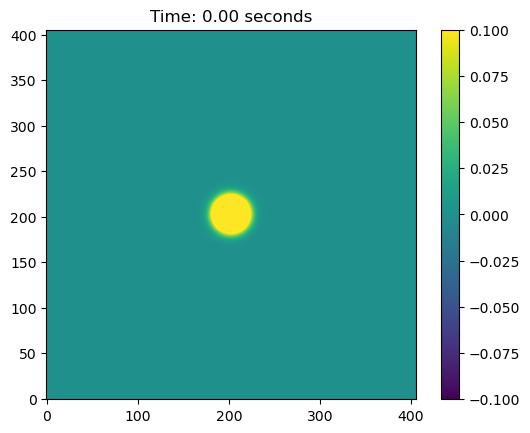

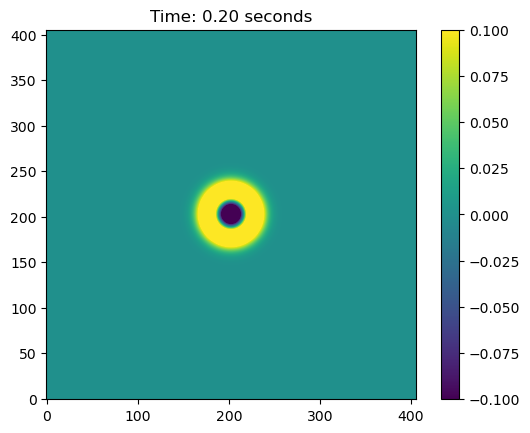

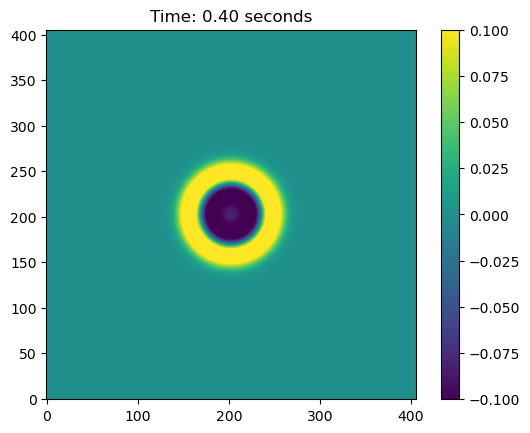

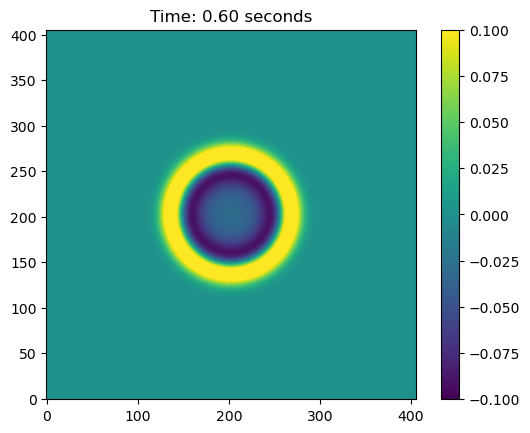

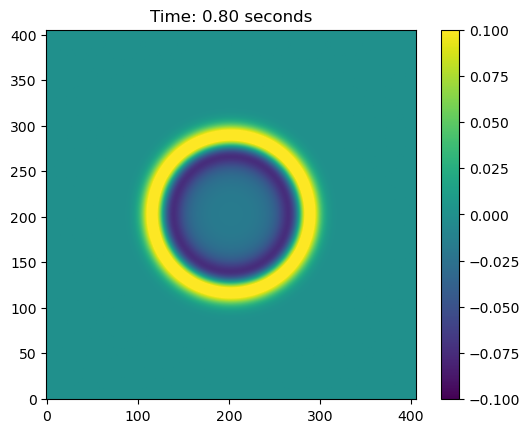

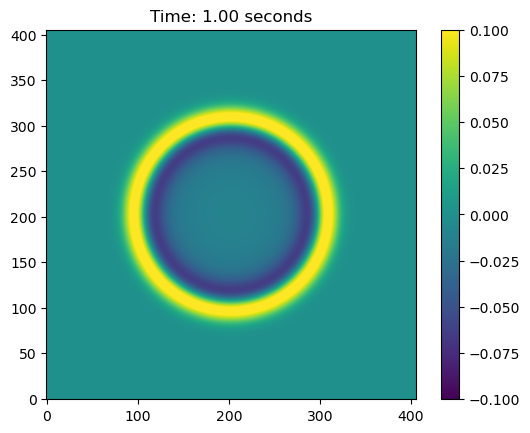

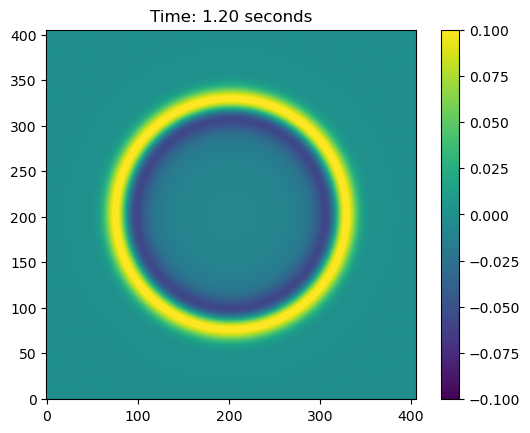

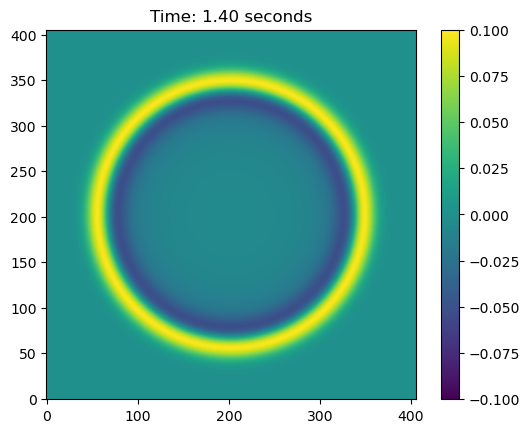

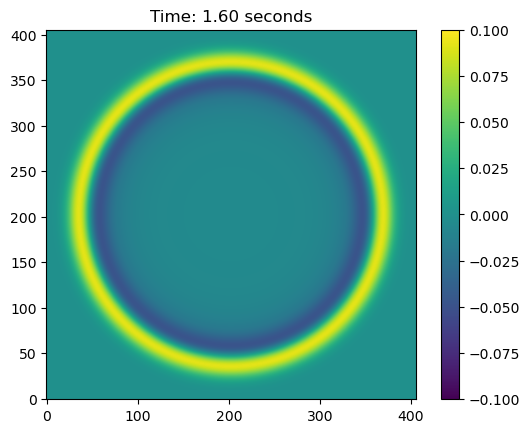

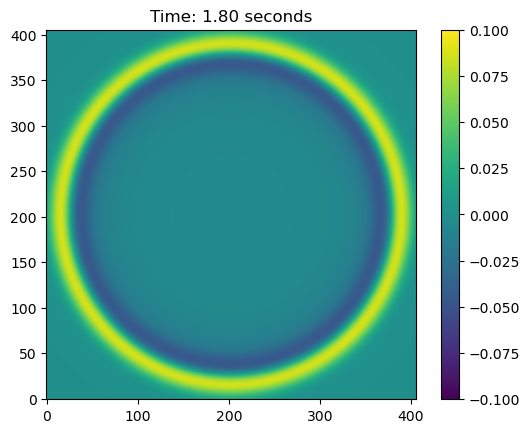

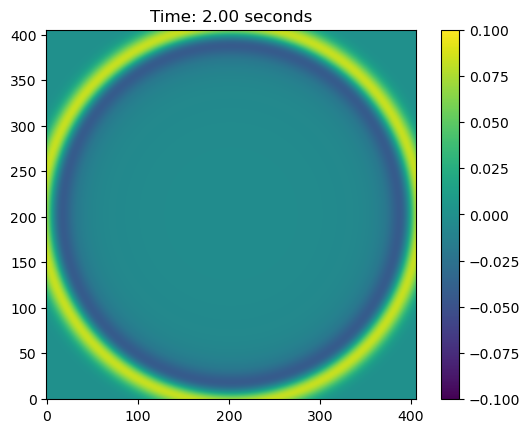

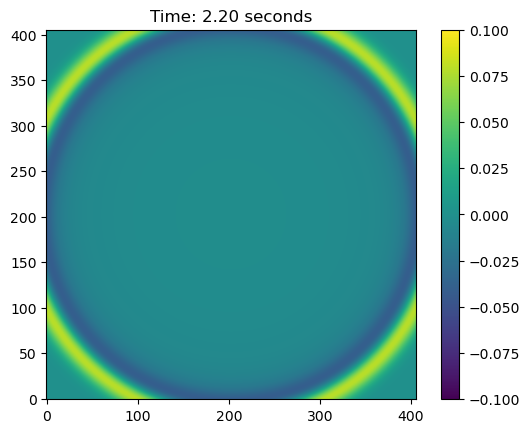

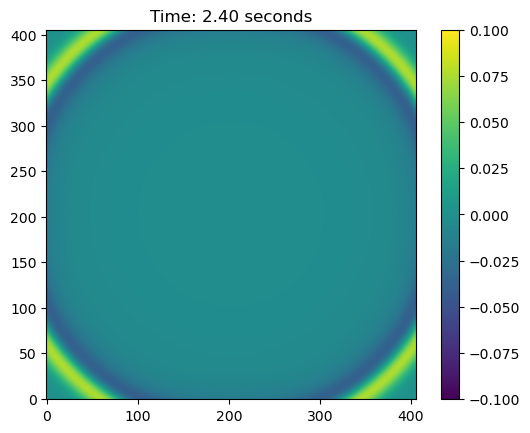

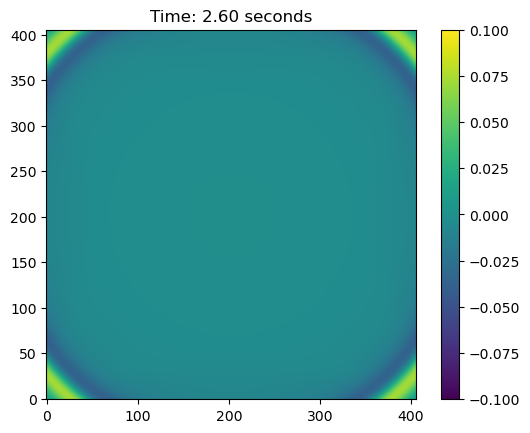

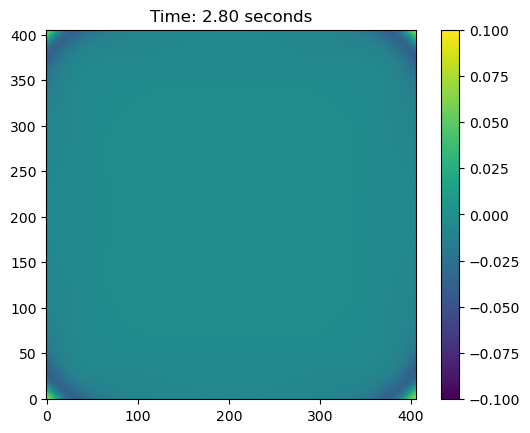

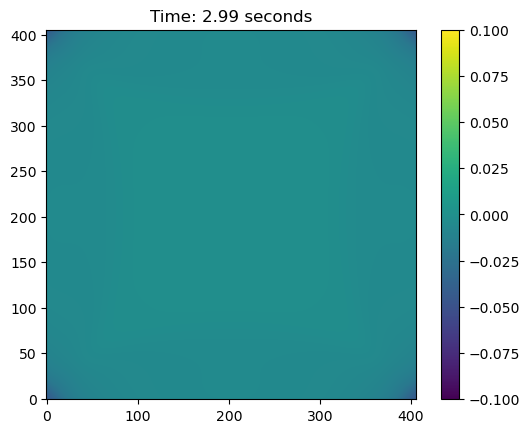

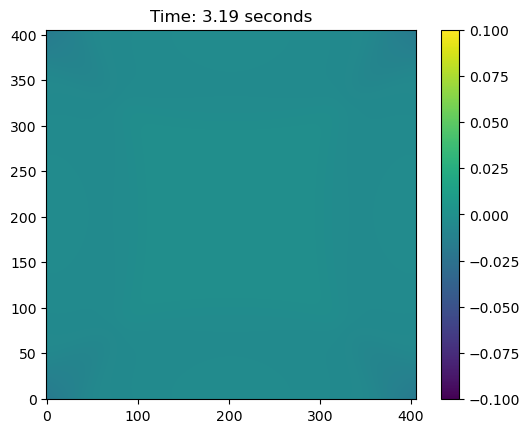

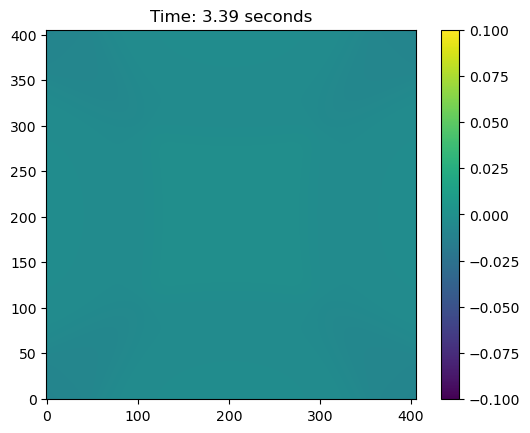

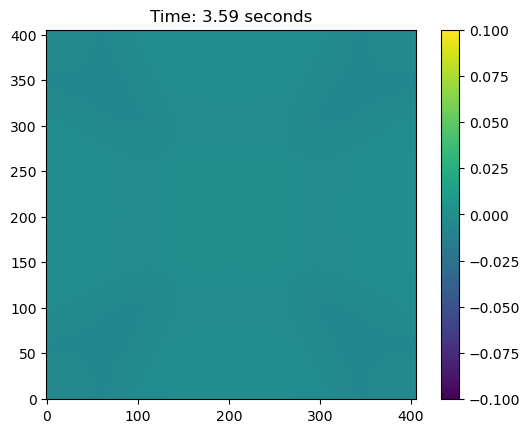

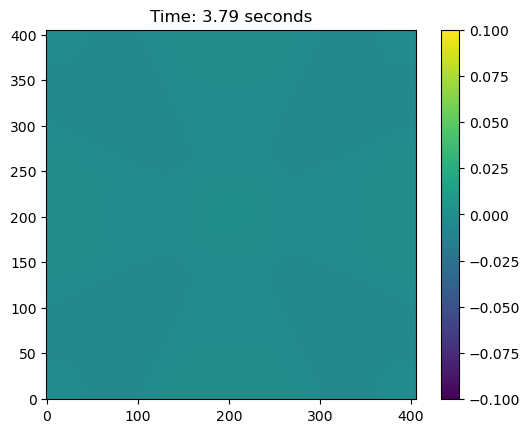

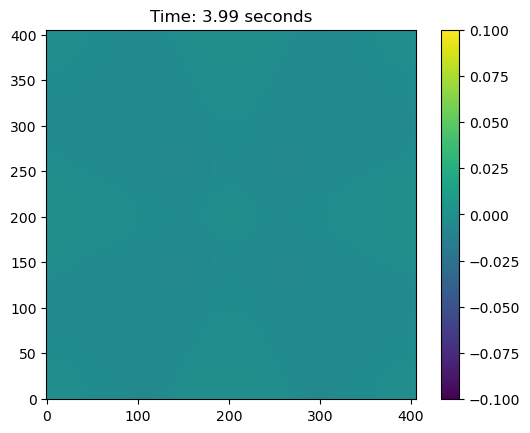

In [14]:
# Plot slices along the third dimension
for it in range(0, 2304, 2304//20):
    plt.imshow(y[:,:,it].T,origin="lower", cmap="viridis",vmin=-0.1, vmax=0.1)
    plt.title(f'Time: {it * 4 / 2304:.2f} seconds')
    plt.colorbar()
    plt.show()

In [15]:
y.shape

(802, 802, 2304)

In [26]:
# Assuming x, y, t, and wavefield are your coordinate and data arrays
# Replace this with your actual arrays

# Generate example coordinate grids
x_coordinates = np.arange(802)
y_coordinates = np.arange(802)
t_coordinates = np.arange(10)

x, y, t = np.meshgrid(x_coordinates, y_coordinates, t_coordinates, indexing='ij')

# Rescale x and y to the range [-4, 4]
x_rescaled = np.interp(x, (x.min(), x.max()), (-4, 4))
y_rescaled = np.interp(y, (y.min(), y.max()), (-4, 4))

# Rescale t to the range [0, 4]
t_rescaled = np.interp(t, (t.min(), t.max()), (0, 4))

# Save the rescaled data along with coordinates
np.savez('your_rescaled_file.npz', x=x_rescaled, y=y_rescaled, t=t_rescaled, wavefield=yw)